In [19]:
from bessel import bessel_roots, J_lx
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

## First step   
Compute the roots of the spherical bessel-functions $j_l(x)$, l $\in$ [0,...,100] and x $\in$ [0,...,100]

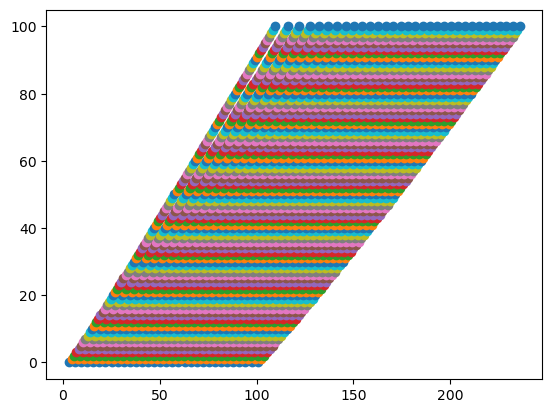

In [2]:
n_roots = 32
l_max = 100
roots = bessel_roots(l_max, n_roots,scipy = True)
for l in range(len(roots)):
    plt.plot(roots[l],l*np.ones(len(roots[l])),'o')

In [3]:
# R = 10 fm
R  = 10 * 1e-15
#now we want to calculate the wavenumbers. we know the relation between the wavenumber and the roots of the besse function
# j_l(k_il R) = 0.
k_il = roots / R

In [9]:
#now we want to check the orthogonality of the spherical bessel functions
#we want to calculate the integral of j_l(k_il R) * j_l(k_il R) * r^2 dr from 0 to R
#for this we use the trapezoidal rule
def trapz(func: callable, a, b, N: int ):
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    return (0.5 * func(a) + np.sum(func(r_i)) + 0.5 * func(b)) * dr

def trapz2(func: callable, a, b, N: int ):
    "trapzoidal rule with for loops"
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    integral = 0
    for i in range(N):
        integral += func(r_i[i])
    return (0.5 * func(a) + integral + 0.5 * func(b)) * dr
    
    
#now we test it with a known function
def f(x):
    return np.sin(x)
print(trapz(f,0,np.pi,200))
print(trapz2(f,0,np.pi,200))
#the known integral is 2

1.9999588764792147
1.9999588764792162


Now we want to check the orthonormality of the spherical bessel-functions. We use the following integral:
$$
\int_0^R j_l(k_{li} r) j_l(k_{lj} r) r^2 dr = \delta_{ij} \frac{1}{\alpha_{ij}^2}
$$
with $\alpha_{ij} = \frac{1}{j_{l-1}(k_{jl R})} \cdot \sqrt{2/R^3}$



In [47]:
def integrand(r,l,j):
    return J_lx(l,k_il[l,j] * r) * J_lx(l,k_il[l,j] * r) * r**2
def integrand2(r,l,j):
    return sp.spherical_jn(l,k_il[l,j] * r) * sp.spherical_jn(l,k_il[l,j] * r) * r**2

#now we want to calculate the integral for different l and j
#we want to store the results in a matrix
l_max = 3
n_roots = 3
integral_ij = np.zeros((l_max,n_roots))
integral_ij2 = np.zeros((l_max,n_roots))
for l in range(l_max):
    for j in range(n_roots):
        def func2(r):
            return integrand2(r,l,j)
        integral_ij2[l,j] = trapz2(func2,0,R,1000)
print(integral_ij2)


[[5.06605918e-44 1.26651480e-44 5.62895465e-45]
 [2.35952246e-44 8.24001300e-45 4.17014634e-45]
 [1.37029837e-44 5.82560247e-45 3.22759430e-45]]


In [34]:
alpha_ij = np.zeros((5,5))
for i in range(0,5):
    alpha_ij[0,i] =  np.sqrt(2/R**3) * i * np.pi
for l in range(1,5):
    for i in range(0,5):
        alpha_ij[l,i] = 1 / J_lx(l-1,k_il[l,i] * R) * np.sqrt(2/R**3)
alpha_ij_sq = alpha_ij ** 2
print(1/alpha_ij)

[[            inf  2.25079079e-22  1.12539540e-22  7.50263597e-23
   5.62697698e-23]
 [-1.53607372e-22  9.07745173e-23 -6.45766702e-23  5.01433881e-23
  -4.09922546e-23]
 [-1.17059744e-22  7.63256344e-23 -5.68119204e-23  4.52919828e-23
  -3.76725551e-23]
 [-9.46203839e-23  6.59523434e-23 -5.07827476e-23  4.13400487e-23
  -3.48790224e-23]
 [-7.93757391e-23  5.81084277e-23 -4.59489647e-23  3.80498682e-23
  -3.24907479e-23]]


/tmp/ipykernel_22936/4169061894.py:8: RuntimeWarning: divide by zero encountered in divide
  print(1/alpha_ij)


In [18]:
print(integral_ij)

[[-1.01308416e-21 -2.53207020e-22 -1.12489083e-22 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.97116945e-15  1.74878154e-15 -2.72871524e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.63411748e-24  1.17150421e-23 -1.12213120e-23 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
